# Tomassini, M. (2023). Designing robust scale-free networks under targeted link attack using local information. 

<a href="https://colab.research.google.com/github/milocortes/mod_04_concentracion/blob/ccm-2023/src/notebooks/python/tomassini_2023_physica_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import math

def edge_degree(u : int, v : int, G : nx.Graph):
    """
    The edge degree d(e) of the edge e = uv is deﬁned as the number of neighbours of e, i.e., |N(u) ∪ N (v)| − 2

    Yoshimoto, K. (2008). Edge degrees and dominating cycles. Discrete mathematics, 308(12), 2594-2599.
    """

    return len(set(G.adj[u]) | set(G.adj[v])) - 2


def edge_a_remover(G : nx.Graph):
    """
    Regresa el la arista con mayor grado
    """
    edges = list(G.edges()) 
    edges_degree = [(edge, edge_degree(*edge, G)) for edge in edges]
    diccionario_ordenado = sorted(edges_degree,  key=lambda item: item[1], reverse = True)

    return diccionario_ordenado[0][0]

def calculateR(G : nx.Graph):
    """
    Notes
    -----
    This function computes Eq.[1] in Ref.[1]

    References
    ----------
    .. [1]Schneider, C. M., Moreira, A. A., Andrade, J. S., Havlin, S., & Herrmann, H. J. (2011).
        Mitigation of malicious attacks on networks.
        Proceedings of the National Academy of Sciences, 108(10), 3838-3841.
    .. [2] Herrmann, H. J., Schneider, C. M., Moreira, A. A., Andrade Jr, J. S., & Havlin, S. (2011).
        Onion-like network topology enhances robustness against malicious attacks.
        Journal of Statistical Mechanics: Theory and Experiment, 2011(01), P01027.
    """
    G = G.copy()
    N = len(G)
    S_q = []
    for _ in range(N-1):
        #maxdeg = max(list(nx.degree(G).values()))
        node_maxdeg = sorted(G.degree, key=lambda x: x[1], reverse=True)[0][0]
        G.remove_node(node_maxdeg)
        largest_connected = max(nx.connected_components(G), key=len)
        S_q.append(len(largest_connected) / N)
    return sum(S_q) / N

def robustness_measures(G_input : nx.Graph, rm_type : str):
    if rm_type == "R(G)":
        return calculateR(G_input)
    elif rm_type == "E(G)":
        return nx.efficiency_measures.global_efficiency(G_input)
    
    

def local_swap(G : nx.Graph):

    bandera = True
    N = len(G.nodes())

    while bandera:
        nodos = list(G.nodes())

        u = np.random.choice(nodos, 1)[0]
        v = np.random.choice(list(G[u]))

        vecinos_u = list(G[u])
        vecinos_v = list(G[v])

        x = np.random.choice(vecinos_u + vecinos_v, 1)[0]
        y = np.random.choice(list(G[x]))

        # Checa si (u,v) y (x,y) son adyacentes, es decir, si comparten
        # algún vértice 
        if len(set((u,v)) & set((x,y))) > 0:
            continue  # same target, skip
        if (x not in G[u]) and (y not in G[v]):  # don't create parallel edges
            G.add_edge(u, x)
            G.add_edge(v, y)
            G.remove_edge(u, v)
            G.remove_edge(x, y)

            n_gigant_component = len(max(nx.connected_components(G), key=len))

            if n_gigant_component == N:
                bandera = False
            else:
                G.remove_edge(u, x)
                G.remove_edge(v, y)
                G.add_edge(u, v)
                G.add_edge(x, y)         

    return G



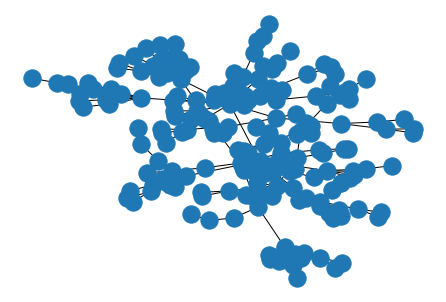

In [2]:
## Creamos una red libre de escala mediante el modelo Barabasi-Albert
n = 200
m = 1
G_BA= nx.barabasi_albert_graph(n, m)

nx.draw(G_BA)
plt.show()

In [3]:
robustness_measures(G_BA, "R(G)")

0.016474999999999903

In [4]:
robustness_measures(G_BA, "E(G)")

0.20286074310948507

In [5]:

def ataque_dirigido(G_input : nx.Graph, porcentaje_minimo : float, porcentaje_maximo : float, muestras : int):
    """
    ### ATAQUE DIRIGIDO

    ## Quitamos las aristas con mayor grado

    ## Proporción de nodos en el componente gigante como medida de robustez

    """
    G_input = G_input.copy()
    m = len(G_input.nodes())
    
    razon_sf = []


    porcentaje_edges_remover = np.linspace( porcentaje_minimo, porcentaje_maximo, muestras)
    total_edges = len(G_input.edges)

    for f in porcentaje_edges_remover:
        # Hacemos una copia de laS gráficas completas para simular el ataque
        G_atacada = G_input.copy()

        # Obtenemos la cantidad de edges a remover
        numero_edges_remover = int(total_edges * f)    

        contador = 0 
        
        while contador <= numero_edges_remover:
            # Seleccionamos de forma aleatoria arista a remover
            edge_remover = edge_a_remover(G_atacada)

            # Removemos la arista en la red
            G_atacada.remove_edge(*edge_remover)

            contador += 1

        # Calculamos eficiencia de la red
        # Calculamos la cantidad de nodos en el componente gigante
        Sf = len(max(nx.connected_components(G_atacada), key=len))

        #print(f"% Aristas removidas {round(f, 3)}. Sf: {Sf/m}")

        razon_sf.append(Sf/m)
    
    return razon_sf

In [6]:
porcentaje_minimo = 0.0
porcentaje_maximo = 0.7
muestras = 20

robustez_original = ataque_dirigido(G_BA, porcentaje_minimo, porcentaje_maximo, muestras)

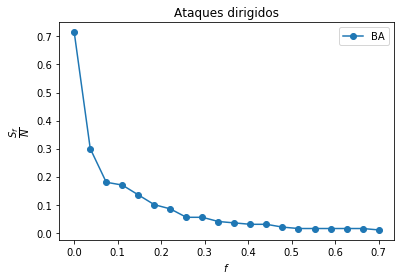

In [7]:
porcentaje_edges_remover = np.linspace( porcentaje_minimo, porcentaje_maximo, muestras)

plt.plot(porcentaje_edges_remover, robustez_original , label = "BA", marker = 'o')
plt.title("Ataques dirigidos")
plt.xlabel(r"$f$")
plt.ylabel(r"$\dfrac{S_f}{N}$")
plt.legend()
plt.show()

In [8]:

def local_reinforcement_algorithm(G_input : nx.Graph, medida : str, iteraciones : int):
    """

    Designing robust scale-free networks under targeted link
    attack using local information

    Marco Tomassini

    Information Systems Institute, University of Lausanne, Switzerland

    Physica A

    """

    #### ALGORITMO LOCAL

    ## Iteramos para distintos N
    ## Medidas de robustez : 
    #    * Eficiencia, E(G)
    #    * R

    # Original E(G)
    RM = robustness_measures(G_input, medida)

    print(f"Original {medida} ---> {RM}")
    print(f"Original Edges ---> {len(G_input.edges())}")

    # Temperatura inicial
    T0 = 4.5 * abs(1 - RM) 
    T = T0
    n_conexiones = []

    RM_reforced = []

    for it in range(1,iteraciones):

        # Creamos copia de la gráfica original 
        G_parcial = G_input.copy()

        # Swap edges:
        #G_parcial = nx.double_edge_swap(G_parcial)
        G_parcial = local_swap(G_parcial)

        # Compute E(g)

        RM_partial = robustness_measures(G_parcial, medida)

        #print(f"It: {it} | E(G*) : {E_BA} | E(G) : {E_BA_partial}")

        if RM_partial > RM:
            G_input = G_parcial.copy()
            RM = RM_partial
        
        
        else:

            # Calculamos delta R
            delta_R = abs(RM - RM_partial)
            # Verificamos si el cambio es aceptado
            r = np.random.uniform(0,1)

            if r <= math.exp(-(delta_R/T)):
                G_input = G_parcial.copy()
                RM = RM_partial
        
        # Compute RM
        if it % 100 == 0:
            print(f"It: {it} | {medida} : {RM:.8f} | Edges : {len(G_input.edges())}")
            RM_reforced.append(RM)

        ponderador = (0.91)**it
        
        if ponderador != 0:
            memoria_ponderador = ponderador
        else:
            ponderador = memoria_ponderador
        T =  ponderador * T0
    
    return G_input, RM_reforced


In [9]:
### Reforzamos la red original con el algoritmo global y métrica R(G)
G_optimizada_R, RM_reforced_ = local_reinforcement_algorithm(G_BA, "R(G)", 4000)

Original R(G) ---> 0.016474999999999903
Original Edges ---> 199
It: 100 | R(G) : 0.01722500 | Edges : 199
It: 200 | R(G) : 0.01995000 | Edges : 199
It: 300 | R(G) : 0.02342500 | Edges : 199
It: 400 | R(G) : 0.02452500 | Edges : 199
It: 500 | R(G) : 0.02637500 | Edges : 199
It: 600 | R(G) : 0.02767500 | Edges : 199
It: 700 | R(G) : 0.02840000 | Edges : 199
It: 800 | R(G) : 0.02870000 | Edges : 199
It: 900 | R(G) : 0.03102500 | Edges : 199
It: 1000 | R(G) : 0.03382500 | Edges : 199
It: 1100 | R(G) : 0.03480000 | Edges : 199
It: 1200 | R(G) : 0.03627500 | Edges : 199
It: 1300 | R(G) : 0.03657500 | Edges : 199
It: 1400 | R(G) : 0.03697500 | Edges : 199
It: 1500 | R(G) : 0.03810000 | Edges : 199
It: 1600 | R(G) : 0.03870000 | Edges : 199
It: 1700 | R(G) : 0.04037500 | Edges : 199
It: 1800 | R(G) : 0.04122500 | Edges : 199
It: 1900 | R(G) : 0.04142500 | Edges : 199
It: 2000 | R(G) : 0.04197500 | Edges : 199
It: 2100 | R(G) : 0.04312500 | Edges : 199
It: 2200 | R(G) : 0.04387500 | Edges : 199

In [10]:
### Reforzamos la red original con el algoritmo global y métrica E(G)
G_optimizada_E, EM_reforced = local_reinforcement_algorithm(G_BA, "E(G)", 4000)

Original E(G) ---> 0.20286074310948507
Original Edges ---> 199
It: 100 | E(G) : 0.21312658 | Edges : 199
It: 200 | E(G) : 0.22160945 | Edges : 199
It: 300 | E(G) : 0.22960270 | Edges : 199
It: 400 | E(G) : 0.23329281 | Edges : 199
It: 500 | E(G) : 0.23467670 | Edges : 199
It: 600 | E(G) : 0.23920703 | Edges : 199
It: 700 | E(G) : 0.23955093 | Edges : 199
It: 800 | E(G) : 0.24005723 | Edges : 199
It: 900 | E(G) : 0.24406531 | Edges : 199
It: 1000 | E(G) : 0.24724665 | Edges : 199
It: 1100 | E(G) : 0.24888490 | Edges : 199
It: 1200 | E(G) : 0.25090829 | Edges : 199
It: 1300 | E(G) : 0.25172350 | Edges : 199
It: 1400 | E(G) : 0.25209249 | Edges : 199
It: 1500 | E(G) : 0.25335559 | Edges : 199
It: 1600 | E(G) : 0.25395023 | Edges : 199
It: 1700 | E(G) : 0.25395023 | Edges : 199
It: 1800 | E(G) : 0.25432292 | Edges : 199
It: 1900 | E(G) : 0.25432292 | Edges : 199
It: 2000 | E(G) : 0.25432292 | Edges : 199
It: 2100 | E(G) : 0.25526334 | Edges : 199
It: 2200 | E(G) : 0.25558220 | Edges : 199


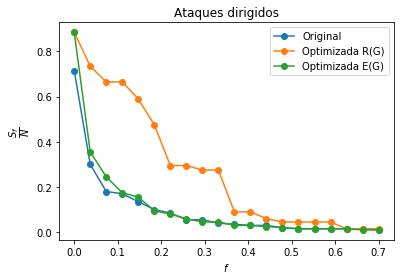

In [11]:
robustez_original = ataque_dirigido(G_BA, porcentaje_minimo, porcentaje_maximo, muestras)
robustez_optimizada_R = ataque_dirigido(G_optimizada_R, porcentaje_minimo, porcentaje_maximo, muestras)
robustez_optimizada_E = ataque_dirigido(G_optimizada_E, porcentaje_minimo, porcentaje_maximo, muestras)

plt.plot(porcentaje_edges_remover, robustez_original , label = "Original", marker = 'o')
plt.plot(porcentaje_edges_remover, robustez_optimizada_R , label = "Optimizada R(G)", marker = 'o')
plt.plot(porcentaje_edges_remover, robustez_optimizada_E , label = "Optimizada E(G)", marker = 'o')

plt.title("Ataques dirigidos")
plt.xlabel(r"$f$")
plt.ylabel(r"$\dfrac{S_f}{N}$")
plt.legend()
plt.show()

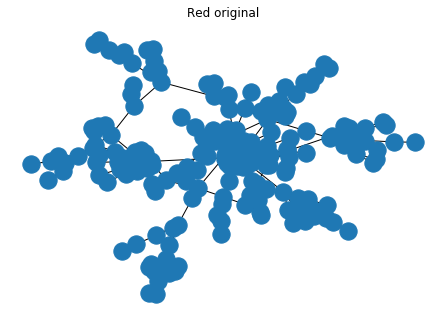

In [12]:
nx.draw(G_BA)
plt.title("Red original")
plt.show()

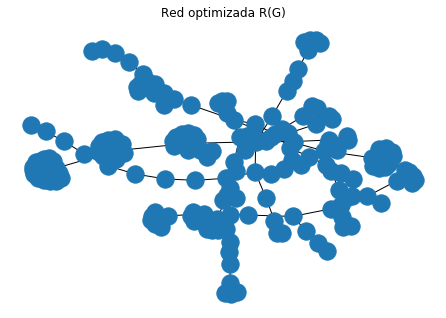

In [13]:
nx.draw(G_optimizada_R)
plt.title("Red optimizada R(G)")
plt.show()

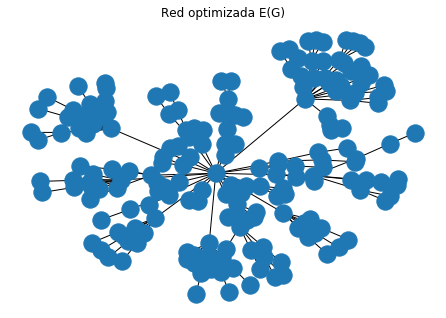

In [14]:
nx.draw(G_optimizada_E)
plt.title("Red optimizada E(G)")
plt.show()